In [ ]:
# This takes amplitudes of fake companions empirically found to be 5-sigma above the noise,
# and calculates a correction term by which the input 5-sigma curve has to be multiplied.

# Created 2020 Mar 19 by E.S.

In [ ]:
# INPUT: list of 
# 1.) Angular distance from host star (asec)
# 2.) Linearly-scaled contrast (i.e., ratio of amplitudes between a fake planet and the host star;
#       0.01 means '0.01 of host star amplitude'). These contrasts are those at which a fake planet
#       has an amplitude such that the signal-to-noise is 5

# OUTPUT: list of
# 1.) Angular distance from host star (asec)
# 2.) Multiplicative factor

In [ ]:
# Ref: Research journal, 2020 Mar 21

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

import matplotlib.pyplot as plt

In [2]:
# read in the empirical 5-sigma linearly-scaled contrast, without correction
# the input curve, as is, represents the relative amplitude at which TPF=0.5, and nothing else

original_contrast_curve = pd.read_csv("data/fake_contrast_curve.csv")

In [44]:
original_contrast_curve

,rad_asec,contrast_lin
0,0.2,0.01000
1,0.4,0.00800
2,0.6,0.00400
3,0.8,0.00350
4,1.0,0.00090
5,1.2,0.00020
6,1.4,0.00018
7,1.6,0.00016
8,1.8,0.00014


In [4]:
# Set some initial constants

# Note that radii are all in units of FWHM unless explicity
# stated otherwise

#### $N_{FP}^{(tot)}=0.01$
#### $R_{max}=20$

In [5]:
N_FP_tot = 0.01
R_max = 20

In [6]:
# Then at each radius we have a constant number of false positives

#### $N_{FP,r}=N_{FP}^{(tot)}/R_{max}$

In [7]:
N_FP_r = np.divide(N_FP_tot,R_max)

In [8]:
print("N_FP_r:")
print(N_FP_r)

N_FP_r:
0.0005


In [9]:
# And thus the FPF is a function of radius:

#### $FPF(r)=\frac{N_{FP,r}}{2\pi r}$

In [10]:
def FPF_r(N_FP_r_pass,N_fwhm_pass):
    '''
    INPUTS:
    N_FP_r_pass: number of false positives at each radius
    #r_fwhm: radius in units of FWHM
    N_fwhm_pass: number of FWHM that can fit in an annulus at that radius
    
    RETURNS:
    FPF at that radius
    '''
    
    #return np.divide(N_FP_r_pass,2*np.pi*r_fwhm_pass)
    return np.divide(N_FP_r_pass,N_fwhm_pass)

In [12]:
# Under the hypothesis H0, the FPF(r) over t-distributed x=F/(s*sqrt(1+(1/n))) where 
# F is the photometry corresponding to a corrected contrast curve
# s is the empirically-found stdev

#### $FPF(r)=\int_{\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [13]:
# This means that tau is where the CDF is 1-FPF (DOFs implied):

#### $CDF(\tau)=1-FPF(r)$

In [14]:
# To find tau, invert the CDF:

In [ ]:
# $\frac{\tau(r)}{\bar{s}(r)}=C_{st}^{-1}(1-FPF(r)|n-1)$

In [ ]:
#### $\frac{\tau(r)}{\bar{s}(r)}=C_{st}^{-1}(1-FPF(r)|n-1)$

In [16]:
# Example CDF inversion:

# generate a t-distribution with 10 DOFs
df = 10
mean, var, skew, kurt = t.stats(df, moments='mvsk')

# print the tau/s-bar where the FPF=0.5 (should be zero!)
print("PPF where FPF=0.5:")
print(t.ppf(0.5, df))

# print the tau/s-bar where the FPF=0.1 (should be negative!)
# and check it with the cdf
print("PPF where FPF=0.1:")
tau_0pt1 = t.ppf(0.1, df)
print(tau_0pt1)
print("Check with CDF (should be 0.1):")
print(t.cdf(tau_0pt1, df))

PPF where FPF=0.5:
6.80574793290978e-17
PPF where FPF=0.1:
-1.3721836411102861
Check with CDF (should be 0.1):
0.10000000000000742


In [17]:
# Now, under the hypothesis H1, consider a fixed TPF.

#### $TPF(r) = \int_{\mu_{c}-\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [18]:
# Inverting, rearranging, and substituting in the expression for the inverted CDF, we have

#### $\frac{\mu_{c}(r)}{\bar{s}(r)} = C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)$

In [19]:
# The fake injected planets are of amplitude N*sbar,
# so just divide those amplitudes by N (which is probably 5).

# The contrast level 'corrected' for small angles is then 

#### $\mu_{c}(r) = \bar{s}(r)\left[C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)\right]$

In [20]:
# Make a function out of this:

In [52]:
def mu_c_5sig(sbar_and_r_asec_pass,TPF_pass=0.95):
    '''
    INPUTS:
    sbar_and_r_asec_pass: pandas dataframe with
        ["contrast_lin"]: linear empirical contrast, or the 's-bar' (implied TPF=0.5 but says nothing else)
        ["rad_asec"]: radius from host star in arcsec
    TPF_pass: the fixed true positive fraction (default 0.95)
    
    OUTPUTS:
    correction_factor: the factor by which to multiply the input 1-sigma contrast curve
    corrected_curve: the actual corrected '5-sigma' curve, found by using the correction factor
    '''

    # initialize a dataframe
    df_corrxn = sbar_and_r_asec_pass.copy(deep=True)
    df_corrxn["mu_c_r_5sig"] = np.nan
    df_corrxn["corrxn_factor"] = np.nan
    df_corrxn["FPF_r"] = np.nan
    # some info in the style of Table 1 in Mawet+ 2014 ApJ 792
    df_corrxn["mu_c_minus_tau"] = np.nan 
    df_corrxn["tau_5_sigma"] = np.nan 
    df_corrxn["tau_3_sigma"] = np.nan 
    
    # find the radii in units of lambda/D FWHM
    # (note FWHM=1.028*lambda/D=(1.028)*(9.463pix)=9.728 pix)
    df_corrxn["rad_fwhm"] = np.divide(np.divide(df_corrxn["rad_asec"],0.0107),9.728)
    print(df_corrxn)
    
    # for each radius, regenerate a noise parent population
    for rad_num in range(0,len(df_corrxn["rad_fwhm"])):
    
        # generate a t-distribution at that radius with DOF_r=rad_fwhm_r-2 because the 
        # point where the fake planet is located is removed, and 1 is subtracted from
        # those which remain
        
        # number of whole-number FWHM that can fit in an annulus at that radius
        # (it needs to be the whole-number floor because of how the Altair 
        # pipeline samples the noise)
        N_FWHM_fit = math.floor(np.multiply(2*np.pi,df_corrxn["rad_fwhm"][rad_num]))
        dof = N_FWHM_fit-2 # degrees of freedom
        
        # generate a t-distribution for that radius
        mean, var, skew, kurt = t.stats(dof, moments='mvsk')
    
        # calculate the FPF at that radius
        FPF_this_r = FPF_r(N_FP_r_pass=N_FP_r,
                           N_fwhm_pass=N_FWHM_fit)
    
        # calculate the first and second Cst^-1 terms in the square brackets
        ppf_1st = t.ppf(1-FPF_this_r, dof)
        ppf_2nd = t.ppf(TPF_pass, dof)
    
        # find the correction factor
        corrxn_factor = (ppf_1st+ppf_2nd)
    
        # and multiply everything with 5*s-bar to get a corrected '5-sigma' curve
        # (note the input contrast_lin is being divided by 5 since the input is '5-sigma')
        print(df_corrxn.keys())
        mu_c_r_5sig = 5.*np.multiply(np.divide(df_corrxn["contrast_lin"].iloc[rad_num],5.),corrxn_factor)        
        df_corrxn.at[rad_num,"mu_c_r_5sig"] = mu_c_r_5sig
        df_corrxn.at[rad_num,"corrxn_factor"] = corrxn_factor
        df_corrxn.at[rad_num,"FPF_r"] = FPF_this_r
        #df_corrxn["mu_c_r_5sig"][rad_num] = mu_c_r_5sig
        #df_corrxn["corrxn_factor"][rad_num] = corrxn_factor

    # just to make things clearer
    df_corrxn = df_corrxn.rename(columns={"contrast_lin": "original_contrast_lim"}) 
    
    # return the completed dataframe
    return df_corrxn

In [53]:
# test with some plots
# (note the input contrast curve has to be divided by 5 first)

In [57]:
test_df = mu_c_5sig(sbar_and_r_asec_pass=original_contrast_curve,
                    TPF_pass=0.95)

   rad_asec  contrast_lin  mu_c_r_5sig  corrxn_factor   rad_fwhm
0       0.2       0.01000          NaN            NaN   1.921422
1       0.4       0.00800          NaN            NaN   3.842843
2       0.6       0.00400          NaN            NaN   5.764265
3       0.8       0.00350          NaN            NaN   7.685686
4       1.0       0.00090          NaN            NaN   9.607108
5       1.2       0.00020          NaN            NaN  11.528529
6       1.4       0.00018          NaN            NaN  13.449951
7       1.6       0.00016          NaN            NaN  15.371372
8       1.8       0.00014          NaN            NaN  17.292794
Index(['rad_asec', 'contrast_lin', 'mu_c_r_5sig', 'corrxn_factor', 'rad_fwhm'], dtype='object')
Index(['rad_asec', 'contrast_lin', 'mu_c_r_5sig', 'corrxn_factor', 'rad_fwhm'], dtype='object')
Index(['rad_asec', 'contrast_lin', 'mu_c_r_5sig', 'corrxn_factor', 'rad_fwhm'], dtype='object')
Index(['rad_asec', 'contrast_lin', 'mu_c_r_5sig', 'corrxn_fact

In [58]:
test_df

,rad_asec,original_contrast_lim,mu_c_r_5sig,corrxn_factor,rad_fwhm
0,0.2,0.01000,0.081642,8.164180,1.921422
1,0.4,0.00800,0.054513,6.814161,3.842843
2,0.6,0.00400,0.026118,6.529586,5.764265
3,0.8,0.00350,0.022470,6.419875,7.685686
4,1.0,0.00090,0.005731,6.367987,9.607108
5,1.2,0.00020,0.001268,6.341354,11.528529
6,1.4,0.00018,0.001139,6.327575,13.449951
7,1.6,0.00016,0.001011,6.320996,15.371372
8,1.8,0.00014,0.000885,6.318718,17.292794


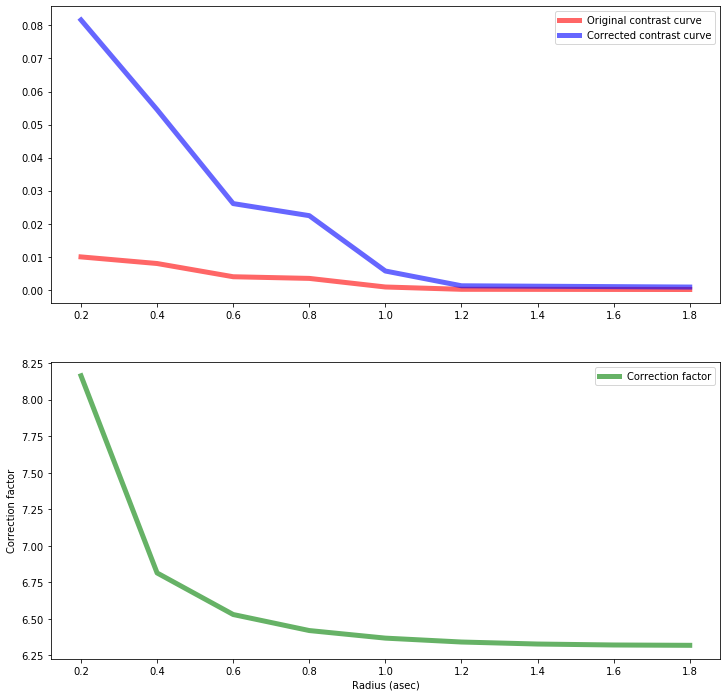

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

ax[0].plot(test_df["rad_asec"], test_df["original_contrast_lim"],'r-', lw=5, alpha=0.6, label="Original contrast curve")
ax[0].plot(test_df["rad_asec"], test_df["mu_c_r_5sig"],'b-', lw=5, alpha=0.6, label="Corrected contrast curve")
ax[1].set_ylabel("Contrast curves")
ax[0].legend()

ax[1].plot(test_df["rad_asec"], test_df["corrxn_factor"],'g-', lw=5, alpha=0.6, label="Correction factor")
ax[1].set_ylabel("Correction factor")
ax[1].set_xlabel("Radius (asec)")
ax[1].legend()

fig.savefig("junk.pdf")